In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
from pathlib import Path
import os
import pandas as pd
import numpy as np

In [94]:
ds.time.max

<bound method DataArrayAggregations.max of <xarray.DataArray 'time' (time: 307803)> Size: 2MB
array(['1990-06-20T21:00:00.000000000', '1990-06-20T22:00:00.000000000',
       '1990-06-20T23:00:00.000000000', ..., '2025-07-31T21:00:00.000000000',
       '2025-07-31T22:00:00.000000000', '2025-07-31T23:00:00.000000000'],
      shape=(307803,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2MB 1990-06-20T21:00:00 ... 2025-07-31T23:...
Attributes:
    long_name:  time
    axis:       T>

In [37]:
# load pre-processed data
data_dir = Path('/Users/juliafiedler/Documents/SL_Hawaii_data/data/')
ds = xr.open_dataset(data_dir / 'rsl_pacific.nc')
station_names = ds.station_name.values
station_ids = ds.station_id.values

filedir = Path(data_dir, '../output/')

# make list to hold all dataframes
data_on_event_list = []

for station in station_ids:
    station_name = station_names[station_ids == station][0]
    NTRcomps_filename = 'SL_NTR_components_' + station_name + '_data_on_event'

    # find all files in filedir that start with NTRcomps_filename
    # and end with .csv
    csv_files = [f for f in os.listdir(filedir) if f.startswith(NTRcomps_filename) and f.endswith('.csv')]
    print(f'Loading {len(csv_files)} files for station {station_name} ({station})')
    for csv_file in csv_files:
        df_temp = pd.read_csv(filedir / csv_file, parse_dates=['time'])
        df_temp['name'] = station_name
        df_temp['station_id'] = station
        data_on_event_list.append(df_temp)

# concatenate all dataframes into one
if data_on_event_list:
    data_on_events = pd.concat(data_on_event_list, ignore_index=True)
else:
    data_on_events = pd.DataFrame()

Loading 2 files for station Funafuti (25)
Loading 1 files for station Nuku'alofa (38)


In [38]:
data_on_events

,Unnamed: 0,time,ntr,sea_level,sea_level_detrended,tide,Rank Tide,Trend,Nodal Amp,Nodal Mod,...,Decadal,Interannual,Seasonal,Subannual,Monthly,Weekly,Storms & HF,rank,name,station_id
0,271420,2024-03-10 05:00:00,-8.507499,3373.0,1272.718692,1281.226191,1.0,2100.281308,6.761202,-11.682648,...,-16.542937,-31.768647,75.467356,-9.471463,-18.697042,10.234468,57.738121,3.0,Funafuti,25
1,270749,2024-02-11 06:00:00,34.423690,3367.0,1267.054176,1232.630486,33.0,2099.945824,6.960843,-2.469587,...,-16.276362,-38.996335,64.020554,-15.485480,26.011358,23.399741,55.770768,6.0,Funafuti,25
2,300947,2024-10-19 08:00:00,57.996897,1993.0,838.473898,780.477000,566.0,1154.526102,-1.010456,17.097544,...,13.285913,-50.791708,-24.818901,22.157339,7.624326,40.951851,24.769177,16.0,Nuku'alofa,38


In [33]:
# get mhhw for each station
epoch_start = np.datetime64('1996-01-01') #<---Following what I believe Phil used??
epoch_end = np.datetime64('2014-12-31')


mhhw_dict = {}
for station in station_ids:
    station_name = station_names[station_ids == station][0]
    mhhw = ds.sel(station_id=station, time=slice(epoch_start, epoch_end)).sea_level.resample(time='1490min').max().mean().item()
    mhhw_dict[station] = mhhw

In [57]:
data_on_event["ntr"]



np.float64(34.42368966565823)

In [60]:
def adjust_axFormat(ax):
    ax.tick_params(axis='y', labelsize=7,which='both',direction='in')
    ax.tick_params(axis='x', labelsize=7,which='both',direction='in')
    ax.yaxis.label.set_size(8)
    ax.xaxis.label.set_size(8)

In [64]:
ntr_component_stds

,ntr,sea_level,sea_level_detrended,tide,Nodal Amp,Nodal Mod,Perigean,Trend,Decadal,Interannual,Seasonal,Subannual,Monthly,Weekly,Storms & HF
0,63.485608,394.082285,388.396369,383.435429,7.968129,16.850269,10.243653,73.133682,25.87065,31.790982,33.19482,24.653144,19.967927,20.001759,21.184142


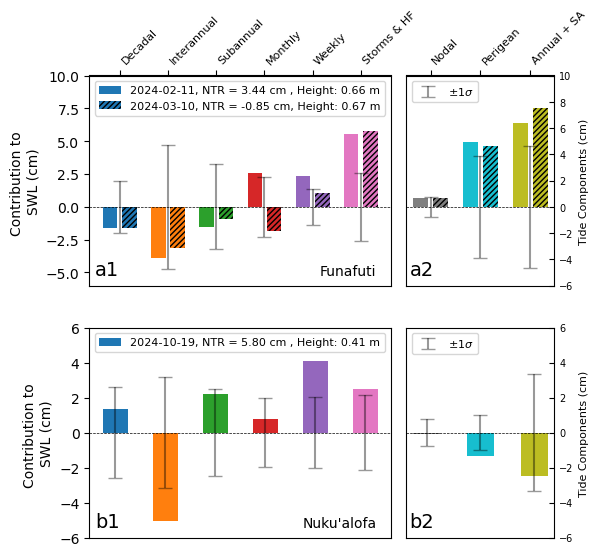

In [93]:
# make timeseries figure


componentsNTR = ['Decadal', 'Interannual', 'Subannual', 'Monthly', 'Weekly', 'Storms & HF']
componentsTide = ['Nodal Amp', 'Perigean', 'Seasonal']

fig, axs = plt.subplots(2,1, figsize=(6, 6))

## Top Plot: Funafuti
ax = axs[0]
station_id = station_ids[station_names == 'Funafuti'][0]
station_name = station_names[station_ids == station_id][0]
mhhw = mhhw_dict[station_id]
csv_file = 'ntr_{:03d}_component_stds.csv'.format(int(station_id))
ntr_component_stds = pd.read_csv(data_dir / 'ntr_data' / csv_file, index_col=0)
ntr_component_stds = ntr_component_stds.T  # Transpose so columns are components


# take first event (in time) for this station
data_on_event = data_on_events[(data_on_events['station_id'] == station_id)].sort_values('time').iloc[0]
data_on_event2 = data_on_events[(data_on_events['station_id'] == station_id)].sort_values('time').iloc[1]
date_str = data_on_event['time'].strftime('%Y-%m-%d')
date_str2 = data_on_event2['time'].strftime('%Y-%m-%d')

component_values = data_on_event[componentsNTR].values.flatten()
component_values2 = data_on_event2[componentsNTR].values.flatten()
hatches = '//////'

x_positions = np.arange(len(componentsNTR))  # Positions for each component
y_stds = 0.1*ntr_component_stds[componentsNTR].values.flatten()

x_positionsTide = np.arange(len(componentsTide)) + 0.4  # Positions for each tide component
y_stdsTide = 0.1*ntr_component_stds[componentsTide].values.flatten()

# we want to include the y_stds from Nodal Mod, but not Nodal Amp, so replace the y_stds with the std of Nodal Mod
# y_stds[components.index('Nodal Amp')] = 0.2*ntr_component_stds['Nodal Mod']

# assign 1 color to each component. There are XX components, so we need XX colors
# component_order = ['Nodal', 'Decadal', 'Interannual', 'Seasonal', 'Subannual', 'Monthly','Weekly', 'Storms & HF']
tab10_colors = plt.cm.tab10.colors
colors = tab10_colors[:5] + tab10_colors[6:7]
colorsTide = tab10_colors[7:10]  # Use the last 3 colors for tide components
component_colors = {comp: colors[i % 6] for i, comp in enumerate(componentsNTR)}
component_colorsTide = {comp: colorsTide[i % 3] for i, comp in enumerate(componentsTide)}
#switch the last two colors in component_colorsTide
component_colorsTide['Seasonal'], component_colorsTide['Perigean'] = component_colorsTide['Perigean'], component_colorsTide['Seasonal']


### --- TOP PLOT: Bar Chart --- ###
bar_width = 0.3

ax.bar(
    x_positions-0.2,
    0.1*component_values,
    alpha=1,
    color=[component_colors[c] for c in componentsNTR],
    width=bar_width,
    label=date_str + ', NTR = ' + f'{0.1*data_on_event["ntr"]:.2f} cm , Height: ' + f"{0.001*(data_on_event['sea_level'] - mhhw):.2f} m"
)
ax.bar(
    x_positions+0.2,
    0.1*component_values2,
    alpha=1,
    color=[component_colors[c] for c in componentsNTR],
    width=bar_width,
    hatch=hatches,
    label=date_str2 + ', NTR = ' + f'{0.1 * data_on_event2["ntr"]:.2f} cm, Height: ' + f"{0.001*(data_on_event2['sea_level'] - mhhw):.2f} m"
)
ax.errorbar(x_positions, np.zeros_like(x_positions), yerr=y_stds, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5)
ax.legend(fontsize=8, frameon=True, loc='upper left')
ax.set_xticks(x_positions)


# Move x-tick labels to the top
ax.set_xticklabels([])
ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(x_positions)
ax_top.set_xticklabels(componentsNTR, rotation=45, ha='left', fontsize=8)

#remove bottom x-ticks
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Title and labels
# ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nSWL (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_ylim([-6, 10])

box = ax.get_position()
#make it skinnier
ax.set_position([box.x0, box.y0, box.width * 0.65, box.height])  # Shrink width to 50%
box_skinny = ax.get_position()
# add another axis on the right for the tide components

ax2 = fig.add_axes([box_skinny.x0 + box_skinny.width+0.025, box.y0, box.width * 0.35-0.025, box.height])  # Create a new Axes on the right side
# Plot tide components

ax2.bar(x_positionsTide-0.2, 0.1*data_on_event[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width)
ax2.bar(x_positionsTide+0.2, 0.1*data_on_event2[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width, hatch=hatches)
ax2.set_ylabel('Tide Components (cm)')
ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)
#remove bottom x-ticks
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.set_ylim([-6,10])
ax2.errorbar(x_positionsTide, np.zeros_like(x_positionsTide), yerr=y_stdsTide, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5, label='$\pm 1\sigma$')
ax.set_xticks(x_positions)

ax2.legend(fontsize=8, frameon=True, loc='upper left')


# Move x-tick labels to the top
ax2.set_xticklabels([])
ax2_top = ax2.secondary_xaxis('top')
ax2_top.set_xticks(x_positionsTide)
componentsTide = [comp.replace('Nodal Amp', 'Nodal') for comp in componentsTide]
componentsTide = [comp.replace('Seasonal', 'Annual + SA') for comp in componentsTide]
ax2_top.set_xticklabels(componentsTide, rotation=45, ha='left', fontsize=8)

#put ylabel on the right side
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

adjust_axFormat(ax2)

ax2.text(0.02, 0.03, 'a2', transform=ax2.transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='left')

ax.text(0.02, 0.03, 'a1', transform=ax.transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='left')
        

## Bottom Plot: Nuku'alofa
ax = axs[1]
station_id = station_ids[station_names == 'Nuku\'alofa'][0]
station_name = station_names[station_ids == station_id][0]
mhhw = mhhw_dict[station_id]
csv_file = 'ntr_{:03d}_component_stds.csv'.format(int(station_id))
ntr_component_stds = pd.read_csv(data_dir / 'ntr_data' / csv_file, index_col=0)
ntr_component_stds = ntr_component_stds.T  # Transpose so columns are components

componentsTide = [comp.replace('Nodal', 'Nodal Amp') for comp in componentsTide]
componentsTide = [comp.replace('Annual + SA', 'Seasonal') for comp in componentsTide]


# take first event (in time) for this station
data_on_event = data_on_events[(data_on_events['station_id'] == station_id)].sort_values('time').iloc[0]
# data_on_event2 = data_on_events[(data_on_events['station_id'] == station_id)].sort_values('time').iloc[1]
date_str = data_on_event['time'].strftime('%Y-%m-%d')
# date_str2 = data_on_event2['time'].strftime('%Y-%m-%d')

component_values = data_on_event[componentsNTR].values.flatten()
# component_values2 = data_on_event2[componentsNTR].values.flatten()
hatches = '//////'

x_positions = np.arange(len(componentsNTR))  # Positions for each component
y_stds = 0.1*ntr_component_stds[componentsNTR].values.flatten()

x_positionsTide = np.arange(len(componentsTide)) + 0.4  # Positions for each tide component
y_stdsTide = 0.1*ntr_component_stds[componentsTide].values.flatten()

# we want to include the y_stds from Nodal Mod, but not Nodal Amp, so replace the y_stds with the std of Nodal Mod
# y_stds[components.index('Nodal Amp')] = 0.2*ntr_component_stds['Nodal Mod']

# assign 1 color to each component. There are XX components, so we need XX colors
# component_order = ['Nodal', 'Decadal', 'Interannual', 'Seasonal', 'Subannual', 'Monthly','Weekly', 'Storms & HF']
tab10_colors = plt.cm.tab10.colors
colors = tab10_colors[:5] + tab10_colors[6:7]
colorsTide = tab10_colors[7:10]  # Use the last 3 colors for tide components
component_colors = {comp: colors[i % 6] for i, comp in enumerate(componentsNTR)}
component_colorsTide = {comp: colorsTide[i % 3] for i, comp in enumerate(componentsTide)}
#switch the last two colors in component_colorsTide
component_colorsTide['Seasonal'], component_colorsTide['Perigean'] = component_colorsTide['Perigean'], component_colorsTide['Seasonal']


### --- TOP PLOT: Bar Chart --- ###
bar_width = 0.5

ax.bar(
    x_positions,
    0.1*component_values,
    alpha=1,
    color=[component_colors[c] for c in componentsNTR],
    width=bar_width,
    label=date_str + ', NTR = ' + f'{0.1*data_on_event["ntr"]:.2f} cm , Height: ' + f"{0.001*(data_on_event['sea_level'] - mhhw):.2f} m"
)

ax.errorbar(x_positions, np.zeros_like(x_positions), yerr=y_stds, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5)
ax.legend(fontsize=8, frameon=True, loc='upper left')
ax.set_xticks(x_positions)


# Move x-tick labels to the top
# ax.set_xticklabels([])
# ax_top = ax.secondary_xaxis('top')
# ax_top.set_xticks(x_positions)
# ax_top.set_xticklabels(componentsNTR, rotation=45, ha='left', fontsize=8)

#remove bottom x-ticks
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Title and labels
# ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nSWL (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_ylim([-6, 6])

box = ax.get_position()
#make it skinnier
ax.set_position([box.x0, box.y0, box.width * 0.65, box.height])  # Shrink width to 50%
box_skinny = ax.get_position()
# add another axis on the right for the tide components

ax2 = fig.add_axes([box_skinny.x0 + box_skinny.width+0.025, box.y0, box.width * 0.35-0.025, box.height])  # Create a new Axes on the right side
# Plot tide components

ax2.bar(x_positionsTide, 0.1*data_on_event[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width)
# ax2.bar(x_positionsTide+0.2, 0.1*data_on_event2[componentsTide].values.flatten(), alpha=1, color = [component_colorsTide[c] for c in componentsTide], width=bar_width, hatch=hatches)
ax2.set_ylabel('Tide Components (cm)')
ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)
#remove bottom x-ticks
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.set_ylim([-6,6])
ax2.errorbar(x_positionsTide, np.zeros_like(x_positionsTide), yerr=y_stdsTide, fmt='none', color='black',alpha=0.4, markersize=3, capsize=5, label='$\pm 1\sigma$')
ax.set_xticks(x_positions)

ax2.legend(fontsize=8, frameon=True, loc='upper left')


# # Move x-tick labels to the top
# ax2.set_xticklabels([])
# ax2_top = ax2.secondary_xaxis('top')
# ax2_top.set_xticks(x_positionsTide)
# componentsTide = [comp.replace('Nodal Amp', 'Nodal') for comp in componentsTide]
# componentsTide = [comp.replace('Seasonal', 'Annual + SA') for comp in componentsTide]
# ax2_top.set_xticklabels(componentsTide, rotation=45, ha='left', fontsize=8)

#put ylabel on the right side
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

adjust_axFormat(ax2)

ax2.text(0.02, 0.03, 'b2', transform=ax2.transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='left')

ax.text(0.02, 0.03, 'b1', transform=ax.transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='left')
        
# add station info on the bottom xlabel

for i,ax in enumerate(axs):
    ax.text(0.95, 0.1, station_names[i], transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right')


figName = 'NTR_Components_BarChart_Funafuti_Nukualofa'
savepath = Path(filedir, figName + '.png')
fig.savefig(savepath, dpi=300, bbox_inches='tight')